# A self-contained tutorial on Lagrangian Neural Networks (LNNs)
Sam Greydanus (this notebook), Miles Cranmer (derivation), Stephan Hoyer (derivation, code)

$\quad$

![LNNs](https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/lnn.png)

$\quad$

## Summary

We propose Lagrangian Neural Networks (LNNs), which harness the expressive power of neural networks to learn arbitrary Lagrangians from data. In contrast to [Hamiltonian Neural Networks](https://greydanus.github.io/2019/05/15/hamiltonian-nns/), these models do not require canonical coordinates and perform well in situations where generalized momentum is difficult to compute (eg the [double pendulum](https://diego.assencio.com/?index=e5ac36fcb129ce95a61f8e8ce0572dbf)). This is particularly appealing for use with a learned latent representation, though this application is a work in progress. Unlike [previous work on learning Lagrangians](https://arxiv.org/pdf/1907.04490.pdf), LNNs can learn arbitrary Lagrangians.

|	| Neural Networks  | [Neural ODEs](https://arxiv.org/abs/1806.07366) | [HNNs](https://arxiv.org/abs/1906.01563)  | [DeLaN (ICLR'19)](https://arxiv.org/abs/1907.04490) | LNNs (this work) |
| ------------- |:------------:| :------------:| :------------:| :------------:| :------------:|
| Can model dynamical systems | ✔ | ✔ | ✔ | ✔ | ✔ |
| Learns differential equations | | ✔ | ✔ | ✔ | ✔ |
| Learns exact conservation laws | | | ✔ | ✔ | ✔ |
| Learns from arbitrary coords. |✔ | ✔|| ✔ | ✔ |
| Learns arbitrary Lagrangians | | |  | | ✔ |

## Lagrangians
Following David Morin's [excellent introduction to Lagrangians](http://www.people.fas.harvard.edu/~djmorin/chap6.pdf), we define the Lagrangian as a scalar function $L\equiv T-V$ with $T$ and $V$ as kinetic and potential energies, respectively. It turns out that we can obtain the equations of motion of an arbitrary physical system using the relationship
$$
\frac{d}{dt} \frac{\partial L}{\partial \dot q_j} = \frac{\partial L}{\partial q_j}
$$
We call this the _Euler-Lagrange (E-L) equation_ and we obtain it by requiring that the the quantity
$$S \equiv \int_{t_1}^{t_2} L(q, \dot q, t) dt$$
have a stationary value. In other words, we require that $S$ be at a local minimum, maximum, or saddle point. We call $S$ the "action" of the system, so the E-L relationship is a mathematical tool for describing its "path of stationary action". One way to think of $S$ is as the cost function that Nature minimizes in order to give us the dynamics of the natural world.

## **Step 1: Basic imports**
We will implement this project in [JAX](https://github.com/google/jax).

_Note: getting this version of Jax to find the GPU is a little iffy, and yet we need its version of the `odeint` function. Our  workaround is to run the following cell, restart the Colab runtime (but don't do "Factory reset runtime"), and then run the next cell._

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.experimental import stax
from jax.experimental import optimizers

# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy.editor import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

### Make sure we're using a GPU

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


## **Step 2: Model the Double Pendulum**
Following [Diego Assencio's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6), the Lagrangian of the double pendulum is 

$$
\begin{align}
L = & \frac{1}{2}(m_1 + m_2) l_1^2 \dot{\theta}_1^2 +
	\frac{1}{2}m_2 l_2^2 \dot{\theta}_2^2 + m_2l_1l_2\dot{\theta}_1\dot{\theta}_2
	\cos(\theta_1 - \theta_2)\nonumber\\[3pt]
     &+ (m_1 + m_2) g l_1 \cos\theta_1 + m_2 g l_2\cos\theta_2
\end{align}
$$

<img src="https://raw.githubusercontent.com/greydanus/greydanus.github.io/master/files/double_pend_schema.png">

It's worth noting that the first line in the equation above corresponds to kinetic energy (T) and the second line corresponds to negative potential energy (-V).

In [5]:
def lagrangian(q, q_dot, m1, m2, l1, l2, g):
    t1, t2 = q     # theta 1 and theta 2
    w1, w2 = q_dot # omega 1 and omega 2
    # kinetic energy (T)
    T1 = 0.5 * m1 * (l1 * w1)**2
    T2 = 0.5 * m2 * ((l1 * w1)**2 + (l2 * w2)**2 +
                    2 * l1 * l2 * w1 * w2 * jnp.cos(t1 - t2))
    T = T1 + T2
    # potential energy (V)
    y1 = -l1 * jnp.cos(t1)
    y2 = y1 - l2 * jnp.cos(t2)
    V = m1 * g * y1 + m2 * g * y2
    return T - V

We'll want to check our results against an analytical solution. We can use equations 19-22 and 28 from [Diego's derivation](https://diego.assencio.com/?index=1500c66ae7ab27bb0106467c68feebc6):

\begin{align}
& \alpha_1(\theta_1,\theta_2) ~:=~ \displaystyle\frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right)\cos(\theta_1 - \theta_2)\\
&\alpha_2(\theta_1,\theta_2) ~:=~ \frac{l_1}{l_2}\cos(\theta_1-\theta_2)\\
&\displaystyle f_1(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
-\frac{l_2}{l_1}\left(\frac{m_2}{m_1+m_2}\right) \dot{\theta}_2^2\sin(\theta_1 - \theta_2)
- \frac{g}{l_1} \sin\theta_1 \\
&\displaystyle f_2(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
\frac{l_1}{l_2}\dot{\theta}_1^2\sin(\theta_1-\theta_2) - \frac{g}{l_2} \sin\theta_2 \\
&g_1 := \displaystyle\frac{f_1 - \alpha_1 f_2}{1 - \alpha_1\alpha_2}
\quad\quad
g_2 := \displaystyle\frac{-\alpha_2 f_1 + f_2}{1 - \alpha_1\alpha_2}
\end{align}

Having defined these quantities, we can express the analytical dynamics of the system in matrix form:

$$
\displaystyle\frac{d}{dt}
\left( \begin{matrix} \theta_1 \\[1pt] \theta_2 \\[1pt] \omega_1 \\[1pt] \omega_1 \end{matrix} \right)
=
\left( \begin{matrix} \omega_1 \\ \omega_2 \\ g_1(\theta_1,\theta_2,\omega_1,\omega_2)
\\ g_2(\theta_1,\theta_2,\omega_1,\omega_2) \end{matrix} \right)
$$

In [6]:
def f_analytical(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    t1, t2, w1, w2 = state
    a1 = (l2 / l1) * (m2 / (m1 + m2)) * jnp.cos(t1 - t2)
    a2 = (l1 / l2) * jnp.cos(t1 - t2)
    f1 = -(l2 / l1) * (m2 / (m1 + m2)) * (w2**2) * jnp.sin(t1 - t2) - \
      (g / l1) * jnp.sin(t1)
    f2 = (l1 / l2) * (w1**2) * jnp.sin(t1 - t2) - (g / l2) * jnp.sin(t2)
    g1 = (f1 - a1 * f2) / (1 - a1 * a2)
    g2 = (f2 - a2 * f1) / (1 - a1 * a2)
    return jnp.stack([w1, w2, g1, g2])

## **Step 3: Obtain dynamics from the Lagrangian**
We have written our Lagrangian and now we want to use it to obtain the dynamics of the system. Physicists would ordinarily try applying the Euler-Lagrange relationship in order to compute a set of analytical equations of motion. In this situation, though, our Lagrangian is a neural network. Trying to get an analytic solution from a neural network Lagrangian would be like trying to knit with a plate of spaghetti.

A better idea is to obtain the dynamics through numerical integration, and to do this we'll need an expression for $\ddot q$. Let's begin with the E-L constraint and try to solve for $\ddot q$.

$$
\begin{align}
\frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot q_j} &= \frac{\partial \mathcal{L}}{\partial q_j} & \text{write down the Euler-Lagrange equation} \quad (1)\\
\frac{d}{dt} \nabla_{\dot q} \mathcal{L} &= \nabla_{q} \mathcal{L} & \text{switch to vector notation} \quad (2)\\
(\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})\ddot q + (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L}) \dot q &= \nabla_q \mathcal{L} & \text{expand the time derivative }\frac{d}{dt} \quad (3)\\
\ddot q &= (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q] & \text{use a matrix inverse to solve for } \ddot q \quad (4)\\
\end{align}
$$

**Implementation.** If you look closely at Equation 4, you may notice that it involves both the Hessian and the gradient of a neural network during the forward pass of the LNN. This is not a trivial operation, but modern automatic differentiation makes things surprisingly smooth. Written in JAX, Equation 4 is just a few lines of code
```
q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @
        (jax.grad(lagrangian, 0)(q, q_t)
          - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
```

Big props to Stephan Hoyer for figuring this out. In order to get the full dynamics, we also have to integrate the equation of motion (JAX makes this easy with `odeint`).

In [7]:
def equation_of_motion(lagrangian, state, t=None):
    q, q_t = jnp.split(state, 2)
    q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
    return jnp.concatenate([q_t, q_tt])

def solve_lagrangian(lagrangian, initial_state, **kwargs):
    # We currently run odeint on CPUs only, because its cost is dominated by
    # control flow, which is slow on GPUs.
    @partial(jax.jit, backend='cpu')
    def f(initial_state):
        return odeint(partial(equation_of_motion, lagrangian),
                  initial_state, **kwargs)
    return f(initial_state)

### Helper functions
Here are a few useful helper functions for obtaining dynamics of the system.

In [8]:
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
    L = partial(lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
    return solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def solve_analytical(initial_state, times):
    return odeint(f_analytical, initial_state, t=times, rtol=1e-10, atol=1e-10)

def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
    return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
    k1 = h * f(x, t)
    k2 = h * f(x + k1/2, t + h/2)
    k3 = h * f(x + k2/2, t + h/2)
    k4 = h * f(x + k3, t + h)
    return x + 1/6 * (k1 + 2 * k2 + 2 * k3 + k4)

## **Step 4: Compare Autograd vs. Analytic solutions**
Having rewritten the Euler-Lagrange equation so that we can use automatic differentiation to obtain the dynamics of the system, it's time to make sure that this approach matches the analytic solution. Here, we'll choose a random initial state and obtain dynamics via both "autograd" and "analytic" approaches. Then we'll slightly perturb the analytic solution to measure how sensitive it is to initial conditions. Taken together, these measurements should give us an approximate idea of whether our autograd-based approach is doing something reasonable.


In [9]:
# choose an initial state
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [10]:
# compute dynamics analytically
%time x_analytical = jax.device_get(solve_analytical(x0, t))
noise_coeff_1, noise_coeff_2 = 1e-10, 1e-11
x_perturbed_1 = jax.device_get(solve_analytical(x0 + noise_coeff_1 * noise, t))
x_perturbed_2 = jax.device_get(solve_analytical(x0 + noise_coeff_2 * noise, t))

CPU times: user 496 ms, sys: 14.7 ms, total: 511 ms
Wall time: 510 ms


In [11]:
# compute dynamics via autograd / the rewritten E-L equation
%time x_autograd = jax.device_get(solve_autograd(x0, t))

CPU times: user 1.5 s, sys: 18.9 ms, total: 1.52 s
Wall time: 1.53 s


### Plot a comparison

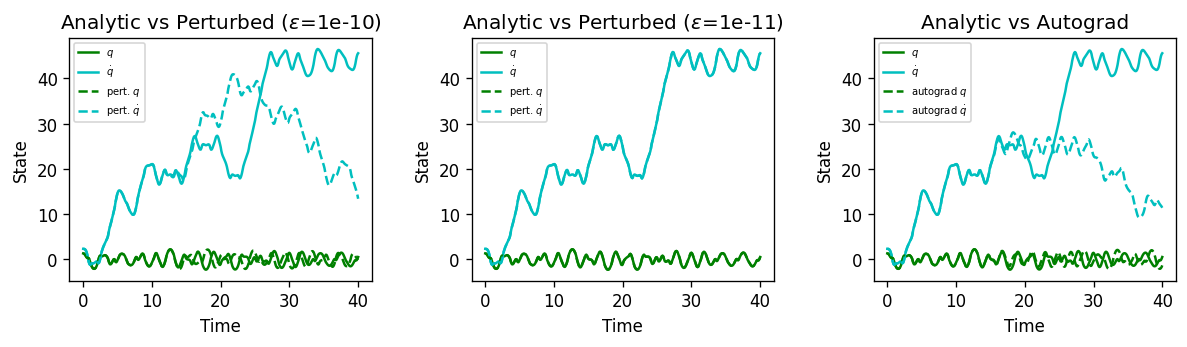

In [12]:
plt.figure(figsize=[10,3], dpi=120) ; plt.xlim(0, 100)
plt.subplot(1,3,1)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_1))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_1[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_1[:, 1], 'c--', label='pert. $\dot q$')
plt.legend(fontsize=6)

plt.subplot(1,3,2)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_2))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_2[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_2[:, 1], 'c--', label='pert. $\dot q$')
plt.legend(fontsize=6)

plt.subplot(1,3,3)
plt.title("Analytic vs Autograd")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_autograd[:, 0], 'g--', label='autograd $q$')
plt.plot(t, x_autograd[:, 1], 'c--', label='autograd $\dot q$')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

## **Step 5: Generate training data**
Let's generate some training data by using the analytical method to sample double pendulum dynamics.


In [13]:
time_step = 0.01
N = 1500
analytical_step = jax.jit(jax.vmap(partial(rk4_step, f_analytical, t=0.0, h=time_step)))

# x0 = np.array([-0.3*np.pi, 0.2*np.pi, 0.35*np.pi, 0.5*np.pi], dtype=np.float32)
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
t = np.arange(N, dtype=np.float32) # time steps 0 to N
%time x_train = jax.device_get(solve_analytical(x0, t)) # dynamics for first N time steps
%time xt_train = jax.device_get(jax.vmap(f_analytical)(x_train)) # time derivatives of each state
%time y_train = jax.device_get(analytical_step(x_train)) # analytical next step

noise = np.random.RandomState(0).randn(x0.size)
t_test = np.arange(N, 2*N, dtype=np.float32) # time steps N to 2N
%time x_test = jax.device_get(solve_analytical(x0, t_test)) # dynamics for next N time steps
%time xt_test = jax.device_get(jax.vmap(f_analytical)(x_test)) # time derivatives of each state
%time y_test = jax.device_get(analytical_step(x_test)) # analytical next step


CPU times: user 2.75 s, sys: 13.4 ms, total: 2.76 s
Wall time: 2.77 s
CPU times: user 166 ms, sys: 4.56 ms, total: 171 ms
Wall time: 168 ms
CPU times: user 249 ms, sys: 15.7 ms, total: 265 ms
Wall time: 256 ms
CPU times: user 2.34 s, sys: 2.8 ms, total: 2.34 s
Wall time: 2.35 s
CPU times: user 22 ms, sys: 1.75 ms, total: 23.7 ms
Wall time: 21.3 ms
CPU times: user 1.11 ms, sys: 184 µs, total: 1.3 ms
Wall time: 953 µs


### Visualize train and test data

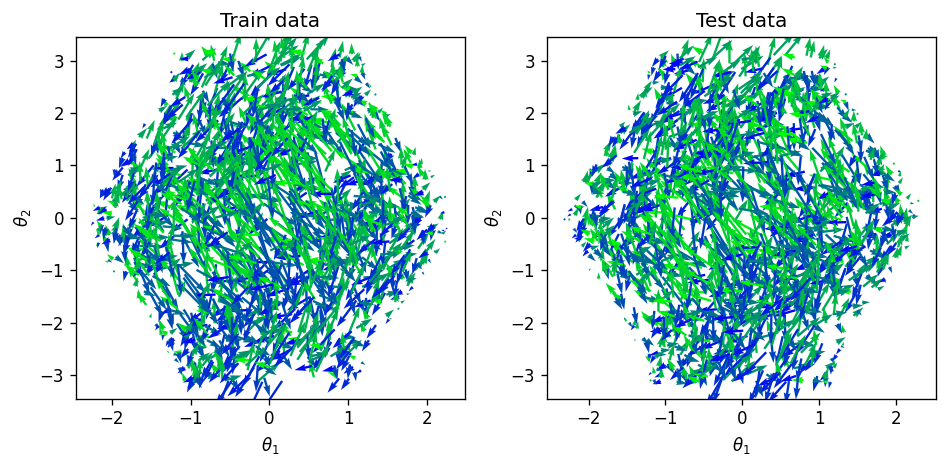

In [14]:
# preprocess
train_vis = jax.vmap(normalize_dp)(x_train)
test_vis = jax.vmap(normalize_dp)(x_test)

vel_angle = lambda data:  (np.arctan2(data[:,3], data[:,2]) / np.pi + 1)/2
vel_color = lambda vangle: np.stack( [np.zeros_like(vangle), vangle, 1-vangle]).T
train_colors = vel_color(vel_angle(train_vis))
test_colors = vel_color(vel_angle(test_vis))

# plot
SCALE = 80 ; WIDTH = 0.006
plt.figure(figsize=[8,4], dpi=120)
plt.subplot(1,2,1)
plt.title("Train data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*train_vis.T, color=train_colors, scale=SCALE, width=WIDTH)

plt.subplot(1,2,2)
plt.title("Test data") ; plt.xlabel(r'$\theta_1$') ; plt.ylabel(r'$\theta_2$')
plt.quiver(*test_vis.T, color=test_colors, scale=SCALE, width=WIDTH)

plt.tight_layout() ; plt.show()

## **Step 6: Build a Lagrangian Neural Network**
This section presents a bare-bones approach to approximating the Lagrangian with a neural network

### i) Build model and define the loss


In [15]:
# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (2,)
    state = normalize_dp(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian

# define the loss of the model (MSE between predicted q, \dot q and targets)
@jax.jit
def loss(params, batch, time_step=None):
  state, targets = batch
  if time_step is not None:
    f = partial(equation_of_motion, learned_lagrangian(params))
    preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state)
  else:
    preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)

# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(128),
    stax.Softplus,
    stax.Dense(1),
)

### ii) Define optimization and data

In [16]:
@jax.jit
def update_timestep(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

@jax.jit
def update_derivative(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, None), opt_state)

x_train = jax.device_put(jax.vmap(normalize_dp)(x_train))
y_train = jax.device_put(y_train)

x_test = jax.device_put(jax.vmap(normalize_dp)(x_test))
y_test = jax.device_put(y_test)

### iii) Train the model

In [ ]:
%%time

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# numbers in comments denote stephan's settings
batch_size = 100
test_every = 10
num_batches = 1500

train_losses = []
test_losses = []

# adam w learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

for iteration in range(batch_size*num_batches + 1):
  if iteration % batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (x_train, xt_train))
    train_losses.append(train_loss)
    test_loss = loss(params, (x_test, xt_test))
    test_losses.append(test_loss)
    if iteration % (batch_size*test_every) == 0:
      print(f"iteration={iteration}, train_loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_derivative(iteration, opt_state, (x_train, xt_train))

params = get_params(opt_state)

iteration=0, train_loss=6770.343262, test_loss=3622.068359
iteration=1000, train_loss=169.297623, test_loss=168.313889
iteration=2000, train_loss=161.099045, test_loss=160.026306
iteration=3000, train_loss=125.255173, test_loss=122.749809
iteration=4000, train_loss=91.444679, test_loss=88.034096
iteration=5000, train_loss=75.360680, test_loss=75.781616
iteration=6000, train_loss=46.178875, test_loss=49.717274
iteration=7000, train_loss=21.446693, test_loss=24.112526
iteration=8000, train_loss=13.089152, test_loss=14.980914
iteration=9000, train_loss=7.534961, test_loss=8.482841
iteration=10000, train_loss=5.304184, test_loss=6.063961
iteration=11000, train_loss=4.134124, test_loss=4.881118
iteration=12000, train_loss=3.612806, test_loss=4.266075
iteration=13000, train_loss=2.959390, test_loss=3.402548
iteration=14000, train_loss=2.306312, test_loss=2.693856
iteration=15000, train_loss=1.705712, test_loss=2.067231
iteration=16000, train_loss=2.214559, test_loss=2.446305
iteration=17000,

### iv) Plot losses over training

In [ ]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.yscale('log')
plt.ylim(None, 200)
plt.title('Losses over training')
plt.xlabel("Train step") ; plt.ylabel("Mean squared error")
plt.legend() ; plt.show()

## **Step 7: Visualize what the model has learned**
In this section we'll run some basic sanity checks to see whether the model has learned something that resembles the Lagrangian of the system

### i) Plot predicted vs actual coordinates (we want a 1:1 mapping)


In [ ]:
xt_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_test)

fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
axes[0].scatter(xt_test[:, 2], xt_pred[:, 2], s=6, alpha=0.2)
axes[0].set_title('Predicting $\dot q$')
axes[0].set_xlabel('$\dot q$ actual')
axes[0].set_ylabel('$\dot q$ predicted')
axes[1].scatter(xt_test[:, 3], xt_pred[:, 3], s=6, alpha=0.2)
axes[1].set_title('Predicting $\ddot q$')
axes[1].set_xlabel('$\ddot q$ actual')
axes[1].set_ylabel('$\ddot q$ predicted')
plt.tight_layout()

### ii) Examine the model's performance over the full coordinate space

In [ ]:
# make a meshgrid of possible angles
angle_range = -np.pi + 2 * np.pi * np.arange(100)/100
x_scanned = np.stack(np.meshgrid(angle_range, angle_range, [0.0], [0.0], indexing='ij'), axis=-1).reshape(-1, 4)

In [ ]:
%time xt_actual = jax.vmap(f_analytical)(x_scanned) # actual time derivatives

In [ ]:
%time xt_predicted = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_scanned) # predicted time derivatives

In [ ]:
import xarray
dataarray = xarray.DataArray(np.stack([xt_actual.reshape(100, 100, 4),
                                       xt_predicted.reshape(100, 100, 4)]),
                             dims=['model', 'theta1', 'theta2', 'time_derivative'],
                             coords={'model': ['actual', 'predicted'], 'theta1': angle_range, 'theta2': angle_range})

In [ ]:
dataarray.isel(time_derivative=2).plot.contourf(levels=31, col='model', x='theta1', y='theta2', vmin=-10, vmax=10)
print("Colorscale is \dot theta1")
plt.show()

In [ ]:
dataarray.isel(time_derivative=3).plot.contourf(levels=31, col='model', x='theta1', y='theta2', vmin=-10, vmax=10)
print("Colorscale is \dot theta2")
plt.show()

## **Step 8: Make predictions with the model**
We should be able to simulate the double pendulum with reasonable degree of accuracy.

In [ ]:
# choose an initial state
x1 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)

t2 = np.linspace(0, 20, num=301)
%time x1_analytical = jax.device_get(solve_analytical(x1, t2))
noise_coeff_3 = 1e-3
%time x1_perturbed = jax.device_get(solve_analytical(x1 + noise_coeff_3 * noise, t2))
%time x1_model = jax.device_get(solve_lagrangian(learned_lagrangian(params), x1, t=t2))

In [ ]:
plt.figure(figsize=[6,6], dpi=120) ; plt.xlim(0, 20)
plt.subplot(2,1,1)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_3))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_perturbed[:, 2], 'g--', label=r'$\theta_1$ perturbed')
plt.plot(t2, x1_perturbed[:, 3], 'c--', label=r'$\theta_2$ perturbed')
plt.legend(fontsize=6)

plt.subplot(2,1,2)
plt.title("Analytic vs LNN")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t2, x1_analytical[:, 2], 'g-', label=r'$\theta_1$ exact')
plt.plot(t2, x1_analytical[:, 3], 'c-', label=r'$\theta_2$ exact')
plt.plot(t2, x1_model[:, 2], 'g--', label=r'$\theta_1$ LNN')
plt.plot(t2, x1_model[:, 3], 'c--', label=r'$\theta_2$ LNN')
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()

## **Step 9: Make videos of the system**

We'll use these to get an intuitive sense of how well our model has learned the dynamics

### i) First, we need to define functions for plotting the pendulum
Sam used [this scipy tutorial](https://scipython.com/blog/the-double-pendulum/) and Stephan Hoyer's [wave equation demo for Jax on TPU](https://colab.research.google.com/github/google/jax/blob/master/cloud_tpu_colabs/Wave_Equation.ipynb) to write the following code.

In [ ]:
def make_plot(i, cart_coords, l1, l2, max_trail=30, trail_segments=20, r = 0.05):
    # Plot and save an image of the double pendulum configuration for time step i.
    plt.cla()

    x1, y1, x2, y2 = cart_coords
    ax.plot([0, x1[i], x2[i]], [0, y1[i], y2[i]], lw=2, c='k') # rods
    c0 = Circle((0, 0), r/2, fc='k', zorder=10) # anchor point
    c1 = Circle((x1[i], y1[i]), r, fc='b', ec='b', zorder=10) # mass 1
    c2 = Circle((x2[i], y2[i]), r, fc='r', ec='r', zorder=10) # mass 2
    ax.add_patch(c0)
    ax.add_patch(c1)
    ax.add_patch(c2)

    # plot the pendulum trail (ns = number of segments)
    s = max_trail // trail_segments
    for j in range(trail_segments):
        imin = i - (trail_segments-j)*s
        if imin < 0: continue
        imax = imin + s + 1
        alpha = (j/trail_segments)**2 # fade the trail into alpha
        ax.plot(x2[imin:imax], y2[imin:imax], c='r', solid_capstyle='butt',
                lw=2, alpha=alpha)

    # Center the image on the fixed anchor point. Make axes equal.
    ax.set_xlim(-l1-l2-r, l1+l2+r)
    ax.set_ylim(-l1-l2-r, l1+l2+r)
    ax.set_aspect('equal', adjustable='box')
    plt.axis('off')
    # plt.savefig('./frames/_img{:04d}.png'.format(i//di), dpi=72)

def radial2cartesian(t1, t2, l1, l2):
  # Convert from radial to Cartesian coordinates.
  x1 = l1 * np.sin(t1)
  y1 = -l1 * np.cos(t1)
  x2 = x1 + l2 * np.sin(t2)
  y2 = y1 - l2 * np.cos(t2)
  return x1, y1, x2, y2

def fig2image(fig):
  fig.canvas.draw()
  data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
  image = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  return image

### ii) Next, we'll make a movie of the pendulum's analytic dynamics

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

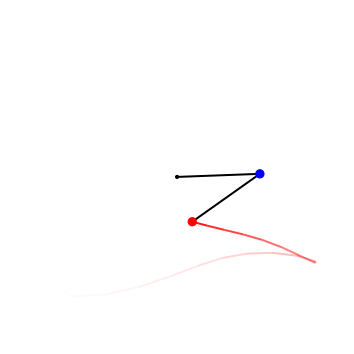

In [ ]:
L1, L2 = 1, 1
theta1, theta2 = x1_analytical[:, 0], x1_analytical[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

import warnings
warnings.filterwarnings("ignore")

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append( fig2image(fig) )

In [ ]:
import importlib
importlib.reload(proglog)
print("True (analytical) dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

True (analytical) dynamics of the double pendulum:


### ii) Now let's visualize the LNN's dynamics

0/300
1/300 2/300 3/300 4/300 5/300 6/300 7/300 8/300 9/300 10/300 11/300 12/300 13/300 14/300 15/300 16/300 17/300 18/300 19/300 20/300
21/300 22/300 23/300 24/300 25/300 26/300 27/300 28/300 29/300 30/300 31/300 32/300 33/300 34/300 35/300 36/300 37/300 38/300 39/300 40/300
41/300 42/300 43/300 44/300 45/300 46/300 47/300 48/300 49/300 50/300 51/300 52/300 53/300 54/300 55/300 56/300 57/300 58/300 59/300 60/300
61/300 62/300 63/300 64/300 65/300 66/300 67/300 68/300 69/300 70/300 71/300 72/300 73/300 74/300 75/300 76/300 77/300 78/300 79/300 80/300
81/300 82/300 83/300 84/300 85/300 86/300 87/300 88/300 89/300 90/300 91/300 92/300 93/300 94/300 95/300 96/300 97/300 98/300 99/300 100/300
101/300 102/300 103/300 104/300 105/300 106/300 107/300 108/300 109/300 110/300 111/300 112/300 113/300 114/300 115/300 116/300 117/300 118/300 119/300 120/300
121/300 122/300 123/300 124/300 125/300 126/300 127/300 128/300 129/300 130/300 131/300 132/300 133/300 134/300 135/300 136/300 137/300 138/30

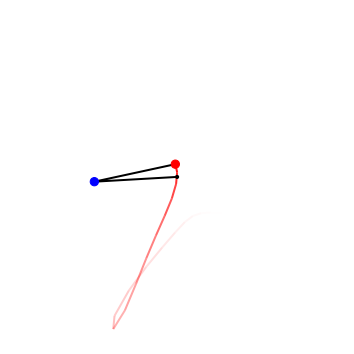

In [ ]:
L1, L2 = 1, 1
theta1, theta2 = x1_model[:, 0], x1_model[:, 1]
cart_coords = radial2cartesian(theta1, theta2, L1, L2)

fig = plt.figure(figsize=(8.3333, 6.25), dpi=72)
ax = fig.add_subplot(111)

images = []
di = 1
N = 300
for i in range(0, N, di):
  print("{}/{}".format(i // di, N // di), end='\n' if i//di%20==0 else ' ')
  make_plot(i, cart_coords, L1, L2)
  images.append( fig2image(fig) )

In [ ]:
import importlib
importlib.reload(proglog)
print("LNN-predicted dynamics of the double pendulum:")
proglog.default_bar_logger = partial(proglog.default_bar_logger, None)
ImageSequenceClip(images, fps=25).ipython_display()

LNN-predicted dynamics of the double pendulum:


In [ ]:
def save_movie(images, path, duration=100, loop=0, **kwargs):
  images[0].save(path, save_all=True, append_images=images[1:],
                 duration=duration, loop=loop, **kwargs)
  
# Save GIF.
PIL_images = [Image.fromarray(im, mode='RGB') for im in images]
save_movie(PIL_images, 'double_pend_lnn.gif')
# The movie sometimes takes a second before showing up in the file system.
import time; time.sleep(1)

# Download animation.
from google.colab import files
files.download('double_pend_lnn.gif')

## **Step 10: Conclusions**
We just learned a double pendulum Lagrangian from data! Correction: we learned the double pendulum Lagrangian for a specific case where both arm lengths and both bob masses were 1. Furthermore, all of our train and test data was sampled from a single energy level of the double pendulum. But this is a good first step. These results are exciting because they are better than what an HNN or even a baseline neural ODE could achieve (we also made these comparisons in separate notebooks).

For the purposes of our paper, we learned a model across different energy levels and added better network initializations, training techniques, and more. We also learned the Lagrangians of other physical systems including a 1D wave equation and a particle in a relativistic field. In theory, this approach should generalize well to other systems and to non-canonical coordinate systems such as the latent vector of a VAE.

$\quad$

Thanks for checking out our LNN tutorial, and please contact us with any questions.